# Лабораторная 1
### Белова Полина, Фролова Юлия

### POS - tagger (Polish)

## Польский
Язык флективного строя, синтетический тип
### Генеалогическая классификация:
- Индоевропейские языки
- Славянская ветвь
- Западнославянская группа
- Лехитская подгруппа
Порядок слов в предложении свободный, грамматически не обусловлен, отсутствует определенная фиксированная последовательность членов предложения. И все же наиболее приемлемым порядком слов в польском предложении принято считать такой: подлежащее — сказуемое — дополнение.

In [1]:
from conllu import parse_incr
import numpy as np
import pandas as pd
import string

Функция считывает файлы и создает список списков токенов(all_sent) и список соответствующих им тегов (all_tag)
- тег ['form'] это конкретная словоформа, ['upostag'] соответствующий этой словоформе тег

In [2]:
def read_and_enjoy(filename):
    all_sent = []
    all_tag =[]
    data = open(filename, 'r', encoding='utf-8')
    for sentences in parse_incr(data): #парсим корпусы
        new_tag = []
        sent=[]
        for word in sentences:
            sent.append(word['form'].lower()) #список слов в одном предложении
            new_tag.append(word['upostag']) #список соответствующих им тегов
        all_sent.append(sent) #список списков всех слов
        all_tag.append(new_tag) #список списков всех тегов
    return all_sent, all_tag

In [4]:
pol_train_sents, pol_train_tags = read_and_enjoy("pl_lfg-ud-train.conllu")
pol_test_sents, pol_test_tags = read_and_enjoy("pl_lfg-ud-test.conllu")

In [5]:
from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import os

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Функция для сбора статистики 
- word_freqs - это словарь всех токенов с частотой их встречаемости
- maxlen - максимальная длина предложения в корпусе
- minlen - минимальная длина предложения в корпусе
- num_sent - количество предложений в корпусе
- median - медиана числа слов в предложении
- mean - математическое ожидание
- tags_freqs - словарь всех тегов с их частотностью
- wordtags - просто словарик слов и соответствующих им тегов (на всякий случай)

In [6]:
import collections
def parse_sentences(corpus, corpus1):
    word_freqs = collections.Counter() 
    tags_freqs = collections.Counter() 
    num_sent, maxlen = 0, 0
    wordtags = {}
    lengths = []
    tags = {}
    minlen = 50
    median, mean = 0, 0
    for line in range(len(corpus)):
        for i in range(len(corpus[line])):
            word_freqs[corpus[line][i]] += 1 #собираем все токены с их частотностью
            tags_freqs[corpus1[line][i]] +=1 #все теги с их частотностью
            wordtags[corpus[line][i]] = corpus1[line][i] #словарь токенов и соответствующих им тегов
        if len(corpus[line]) > maxlen:
            maxlen = len(corpus[line]) #вычисляем максимальную длину предложения
        if len(corpus[line]) < minlen:
            minlen = len(corpus[line]) #вычисляем минимальную длину предложения
        lengths.append(len(corpus[line])) #собираем длины всех предложений в список для вычисления медианы и мат ожидания
        num_sent +=1 #вычисляем кол-во предложения
    
    median = np.median(np.array(lengths)) #медиана
    mean = np.mean(np.array(lengths)) #мат ожидание
    return word_freqs, maxlen, minlen, num_sent, median, mean, tags_freqs, wordtags
pol_freqs, pol_max, pol_min, pol_num, pol_median, pol_mean, pol_tags, pol_wordtags = parse_sentences(pol_train_sents, pol_train_tags)
pol_test_freqs, pol_test_max, pol_test_min, pol_test_num, pol_test_median, pol_test_mean, pol_t_tags, pol_test_wordtags = parse_sentences(pol_test_sents, pol_test_tags)

функция вычисления доли новых слов в тестовом корпусе

In [7]:
def new_words(corpus, freqs, freqs1):
    all_words = collections.Counter(freqs + freqs1) # объединяем все слова 
    dolya = round(1 - len(freqs)/len(all_words), 6) # делим кол-во всех знакомых слов на кол-во всех слов и вычитаем из 1
    return dolya, all_words
pol_dolya, pol_all = new_words(pol_test_sents, pol_freqs, pol_test_freqs)

In [8]:
print ('Число предложений: %d\nЧисло уникальных словоформ: %d\nЧисло уникальных PoS-тегов: %d\nМакс слов:%d\nМин слов:%d\nМат ожидание:%f\nМедиана:%f\nДоля новых слов:%f' % (pol_num, len(pol_freqs), len(pol_tags), pol_max, pol_min, pol_mean, pol_median, pol_dolya))

Число предложений: 13774
Число уникальных словоформ: 25558
Число уникальных PoS-тегов: 15
Макс слов:27
Мин слов:2
Мат ожидание:7.604908
Медиана:7.000000
Доля новых слов:0.076562


### Гистограмма тегов тренировочного корпуса

<Container object of 15 artists>

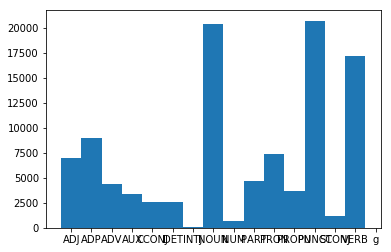

In [9]:
dictionary = dict(pol_tags)
plt.bar(list(dictionary.keys()), dictionary.values(), 'g', align='center')

### Гистограмма тегов тестового корпуса

<Container object of 15 artists>

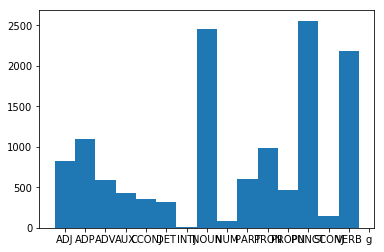

In [10]:
dictionary = dict(pol_t_tags)
plt.bar(list(dictionary.keys()), dictionary.values(), 'g', align='center')

тут не все так ужасно с длиной предложения, как в немецком, поэтому здесь мы решили взять максимальную длину предложения. Токены мы также взяли все, т.к. по сравнению с немецким, их тут намнооооого меньше

In [11]:
MAX_SEQLEN = 27
S_MAX_FEATURES = len(pol_freqs)
T_MAX_FEATURES = 15

кодируем слова и теги уникальным числом, а также добавляем в словари слово для паддингов и незнакомых токенов

In [12]:
pol_word2index = {w[0]: i + 2 for i,w in enumerate(pol_freqs.most_common(S_MAX_FEATURES))}
pol_word2index['PAD'] = 0
pol_word2index['UNK'] = 1
pol_tag2index = {t: i + 1 for i,t in enumerate(pol_tags)}
pol_tag2index['PAD'] = 0

In [13]:
S_MAX_FEATURES += 2 # добавляем к длине токенов 2 (паддинг и незнакомый токен)
T_MAX_FEATURES += 1 # добавляем к длине тегов 1 (паддинг)

In [14]:
NUM_EPOCHS = 8

In [15]:
def build_tensor(sents, numsents, toindex, maxlen):
    data = np.empty((numsents, ), dtype=list)
    i = 0
    for line in sents:
        wids = []
        for word in line:
            if word in toindex:
                wids.append(toindex[word]) # список индексов слов в предложении
            else:
                wids.append(toindex['UNK']) # если не знаем, то записываем индекс 1 (незнакомое слово)
        data[i] = wids
        i += 1
    pdata = sequence.pad_sequences(data, maxlen=maxlen, padding='post', truncating="post") # добавляем паддинги до MAX_SEQLEN
    return pdata
X = build_tensor(pol_train_sents, pol_num, pol_word2index, MAX_SEQLEN)
Xtest = build_tensor(pol_test_sents, pol_test_num, pol_word2index, MAX_SEQLEN)
Y = build_tensor(pol_train_tags, pol_num, pol_tag2index, MAX_SEQLEN)
Ytest = build_tensor(pol_test_tags, pol_test_num, pol_tag2index, MAX_SEQLEN)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42) # из тренировочную корпуса берем часть на валидацию

функция, которая оценивает работу модели без паддингов

In [16]:
# y - correct answers - tags
# h - predictions
def evaluate(y, h, test_tags):
    new_y = []
    new_h = []
    for line in y:
        k = 0
        for i in range(len(test_tags[k])):
            new_y.append(line[i])
        k+=1
    for line in h:
        k = 0
        for i in range(len(test_tags[k])):
            new_h.append(line[i])
        k+=1
    
        
    classes = set(new_y)
    len_new_y = len(new_y)

    results = {'accuracy w/o paddings': 0}
    class_dist = {c: new_y.count(c) / len_new_y for c in classes}

    for c in classes:
        tp = set()
        fp = set()
        tn = set()
        fn = set()

        for i, h_i in enumerate(new_h):
            y_i = new_y[i]
            if h_i == y_i:
                if h_i == c:
                    tp.add((i, h_i))
                else:
                    tn.add((i, h_i))
        acc = len(tp | tn) / len(new_h) # так как мы в метриках оценивания используем только точность, то и здесь подсчитаем только ее

        results['accuracy w/o paddings']  += acc * class_dist[c]
    return results

### SimpleRNN

во всех моделях 
- batch_size=64
- hidden_layer=64
- размеры эмбеддингов для моделей: 64, 100, 200
- activation - softmax, loss - categorical_crossentropy, потому что это задача классификации
- оптимизатор adam, т.к. с ним еще не работали, но он в принципе похож на rmsprop

In [17]:
from keras.layers import SimpleRNN

In [18]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 27, 64)            1635840   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 27, 64)            8256      
_________________________________________________________________
dense_1 (Dense)              (None, 27, 16)            1040      
_________________________________________________________________
activation_1 (Activation)    (None, 27, 16)            0         
Total params: 1,645,136
Trainable params: 1,645,136
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os
os.makedirs('cu\\rnn_model\\cu-easy_model-{epoch}.h5')
os.makedirs('cu\\rnn_model\\cu-easy_model-history.json')
os.makedirs('cu\\lstm_model\\cu-easy_model-{epoch}.h5')
os.makedirs('cu\\lstm_model\\cu-easy_model-history.json')
os.makedirs('cu\\bilstm_model\\cu-easy_model-{epoch}.h5')
os.makedirs('cu\\bilstm_model\\cu-easy_model-history.json')
os.makedirs('cu\\gru_model\\cu-easy_model-{epoch}.h5')
os.makedirs('cu\\gru_model\\cu-easy_model-history.json')

сохраняем веса для каждой эпохи, что потом по эпохе до переобучения сделать предсказания и посчитать точность модели без паддингов

In [19]:
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 8s 742us/step - loss: 0.9427 - acc: 0.7401 - val_loss: 0.5860 - val_acc: 0.8445

Epoch 00001: saving model to cu\rnn_model\cu-easy_model-1.h5
Epoch 2/8
11019/11019 [==============================] - 6s 551us/step - loss: 0.4726 - acc: 0.8813 - val_loss: 0.3525 - val_acc: 0.9090

Epoch 00002: saving model to cu\rnn_model\cu-easy_model-2.h5
Epoch 3/8
11019/11019 [==============================] - 7s 677us/step - loss: 0.2688 - acc: 0.9334 - val_loss: 0.2005 - val_acc: 0.9466

Epoch 00003: saving model to cu\rnn_model\cu-easy_model-3.h5
Epoch 4/8
11019/11019 [==============================] - 7s 679us/step - loss: 0.1398 - acc: 0.9667 - val_loss: 0.1338 - val_acc: 0.9607

Epoch 00004: saving model to cu\rnn_model\cu-easy_model-4.h5
Epoch 5/8
11019/11019 [==============================] - 7s 651us/step - loss: 0.0731 - acc: 0.9843 - val_loss: 0.1104 - val_acc: 0.9649

Epoch 00005: savi

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [21]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-8.h5') #вызываем веса для лучше эпохи
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64) 
print(acc) #подсчитываем точность на тестовой выборке
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_rnn)

1727/1727 [==============================] - 0s 62us/step
0.968560336501735
{'accuracy w/o paddings': 0.9157176864183235}


строим графики

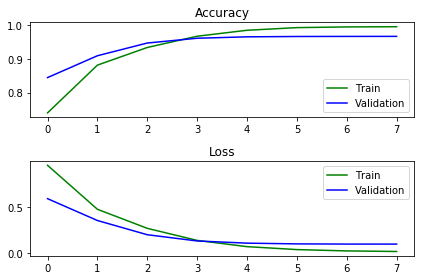

In [22]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 100

In [23]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 100, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 27, 100)           2556000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 27, 64)            10560     
_________________________________________________________________
dense_2 (Dense)              (None, 27, 16)            1040      
_________________________________________________________________
activation_2 (Activation)    (None, 27, 16)            0         
Total params: 2,567,600
Trainable params: 2,567,600
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 11s 985us/step - loss: 0.8600 - acc: 0.7732 - val_loss: 0.5329 - val_acc: 0.8619

Epoch 00001: saving model to cu\rnn_model\cu-easy_model-1.h5
Epoch 2/8
11019

переобучение на 8 эпохе, т.к. валидационная точность начинает падать

In [24]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-7.h5')
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_rnn)

1727/1727 [==============================] - 0s 78us/step
0.9687962449556426
{'accuracy w/o paddings': 0.9163610628578781}


строим графики

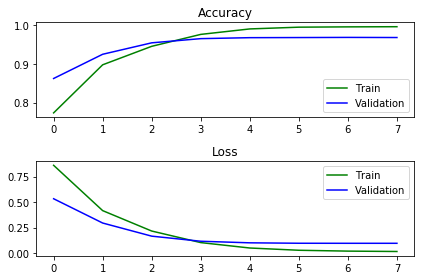

In [25]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 200

In [26]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 200, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 27, 200)           5112000   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 27, 64)            16960     
_________________________________________________________________
dense_3 (Dense)              (None, 27, 16)            1040      
_________________________________________________________________
activation_3 (Activation)    (None, 27, 16)            0         
Total params: 5,130,000
Trainable params: 5,130,000
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 22s 2ms/step - loss: 0.8117 - acc: 0.7867 - val_loss: 0.4927 - val_acc: 0.8731

Epoch 00001: saving model to cu\rnn_model\cu-easy_model-1.h5
Epoch 2/8
11019/1

переобучение на 8 эпохе, т.к. валидационная точность начинает падать

In [27]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-7.h5')
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_rnn)

1727/1727 [==============================] - 0s 110us/step
0.9630058584837259
{'accuracy w/o paddings': 0.9001479765810978}


строим графики

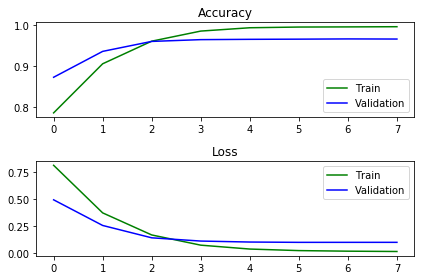

In [28]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| RNN | Размер эмбеддинга | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 64 | нет | 0.9685 | 0.9662 | 0.1003 | 0.9157176864183235 |
| **2 модель** | 100 | 8 | 0.9687 | 0.9678 | 0.097 | 0.9163610628578781 |
| **3 модель** | 200 | 8 | 0.963 | 0.9661 | 0.0994 | 0.9001479765810978 | 

пока гипотезы и заметки по работе моделей:
- чем больше размер эмбеддинга, тем быстрее происходит переобучение(но это не точно, может, будут какие-то случаи, где такого не происходило)
- чем больше размер эмбеддинга, тем, возможно, больше тестовая, валидационная точности и точность без паддингов, а также меньше потери, что логично, т.к. в модель поступает больше параметров
- лучше всего на rnn показала себя модель с размером эмбеддинга 100. Возможно, это произошло из-за того, что модель с эмбеддингом 200 больше переобучилась и показывает данные немного хуже.
- что, в принципе, тоже логично, но проверять мы этого не стали: при увеличении нейронов на скрытом слое, в модель поступает больше параметров -> модель, возможно, будет переобучаться намного раньше, а показатели также увеличатся (хотя, может, только на доли сотых)
- модель предсказывает теги без паддингов вполне хорошо и даже отлично. Это следует из того, что мы взяли весь словарб токенов и впихнули его в модель, а так доля новых слов небольшая, то и предсказывать теги в тестовом корпусе модель будет очень даже хорошо на основе имеющихся уже данных

повторяем те же действия с другими сетями

### LSTM

In [29]:
from keras.layers.recurrent import LSTM

In [30]:
lstm_model = Sequential()
lstm_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
lstm_model.add(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(Dense(T_MAX_FEATURES))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 27, 64)            1635840   
_________________________________________________________________
lstm_1 (LSTM)                (None, 27, 64)            33024     
_________________________________________________________________
dense_4 (Dense)              (None, 27, 16)            1040      
_________________________________________________________________
activation_4 (Activation)    (None, 27, 16)            0         
Total params: 1,669,904
Trainable params: 1,669,904
Non-trainable params: 0
_________________________________________________________________


In [31]:
checkpoint = ModelCheckpoint('cu\\lstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_history = lstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 19s 2ms/step - loss: 1.0027 - acc: 0.7248 - val_loss: 0.6861 - val_acc: 0.7721

Epoch 00001: saving model to cu\lstm_model\cu-easy_model-1.h5
Epoch 2/8
11019/11019 [==============================] - 10s 907us/step - loss: 0.6052 - acc: 0.8128 - val_loss: 0.5359 - val_acc: 0.8356

Epoch 00002: saving model to cu\lstm_model\cu-easy_model-2.h5
Epoch 3/8
11019/11019 [==============================] - 10s 912us/step - loss: 0.4430 - acc: 0.8677 - val_loss: 0.3428 - val_acc: 0.9021

Epoch 00003: saving model to cu\lstm_model\cu-easy_model-3.h5
Epoch 4/8
11019/11019 [==============================] - 10s 893us/step - loss: 0.2498 - acc: 0.9306 - val_loss: 0.1963 - val_acc: 0.9449

Epoch 00004: saving model to cu\lstm_model\cu-easy_model-4.h5
Epoch 5/8
11019/11019 [==============================] - 10s 890us/step - loss: 0.1245 - acc: 0.9702 - val_loss: 0.1372 - val_acc: 0.9560

Epoch 0000

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [32]:
lstm_model.load_weights('cu\\lstm_model\\cu-easy_model-8.h5')
score, acc = lstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = lstm_model.predict_classes(Xtest)
prediction_lstm = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_lstm)

1727/1727 [==============================] - 0s 121us/step
0.9576443860347242
{'accuracy w/o paddings': 0.8861223701988035}


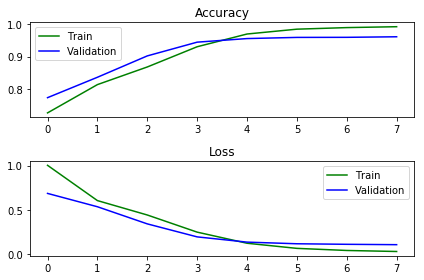

In [33]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(lstm_history.history["acc"], color="g", label="Train")
plt.plot(lstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(lstm_history.history["loss"], color="g", label="Train")
plt.plot(lstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 100

In [34]:
lstm_model = Sequential()
lstm_model.add(Embedding(S_MAX_FEATURES, 100, input_length=MAX_SEQLEN))
lstm_model.add(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(Dense(T_MAX_FEATURES))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()
checkpoint = ModelCheckpoint('cu\\lstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_history = lstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 27, 100)           2556000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 27, 64)            42240     
_________________________________________________________________
dense_5 (Dense)              (None, 27, 16)            1040      
_________________________________________________________________
activation_5 (Activation)    (None, 27, 16)            0         
Total params: 2,599,280
Trainable params: 2,599,280
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 23s 2ms/step - loss: 0.9536 - acc: 0.7252 - val_loss: 0.6612 - val_acc: 0.8015

Epoch 00001: saving model to cu\lstm_model\cu-easy_model-1.h5
Epoch 2/8
11019/

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [35]:
lstm_model.load_weights('cu\\lstm_model\\cu-easy_model-8.h5')
score, acc = lstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = lstm_model.predict_classes(Xtest)
prediction_lstm = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_lstm)

1727/1727 [==============================] - 0s 139us/step
0.9645928518235096
{'accuracy w/o paddings': 0.9044585987261147}


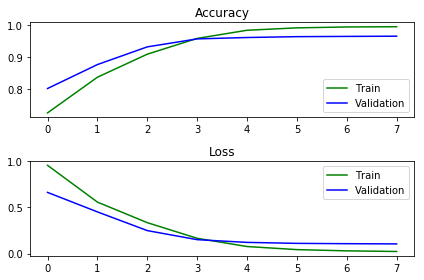

In [36]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(lstm_history.history["acc"], color="g", label="Train")
plt.plot(lstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(lstm_history.history["loss"], color="g", label="Train")
plt.plot(lstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 200

In [37]:
lstm_model = Sequential()
lstm_model.add(Embedding(S_MAX_FEATURES, 200, input_length=MAX_SEQLEN))
lstm_model.add(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm_model.add(Dense(T_MAX_FEATURES))
lstm_model.add(Activation("softmax"))

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
lstm_model.summary()
checkpoint = ModelCheckpoint('cu\\lstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
lstm_history = lstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 27, 200)           5112000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 27, 64)            67840     
_________________________________________________________________
dense_6 (Dense)              (None, 27, 16)            1040      
_________________________________________________________________
activation_6 (Activation)    (None, 27, 16)            0         
Total params: 5,180,880
Trainable params: 5,180,880
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 37s 3ms/step - loss: 0.8767 - acc: 0.7475 - val_loss: 0.5796 - val_acc: 0.8274

Epoch 00001: saving model to cu\lstm_model\cu-easy_model-1.h5
Epoch 2/8
11019/

переобучение на 6 эпохе, т.к. валидационная точность начинает давать сбои

In [38]:
lstm_model.load_weights('cu\\lstm_model\\cu-easy_model-5.h5')
score, acc = lstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = lstm_model.predict_classes(Xtest)
prediction_lstm = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_lstm)

1727/1727 [==============================] - 0s 177us/step
0.96193355746399
{'accuracy w/o paddings': 0.898346522550344}


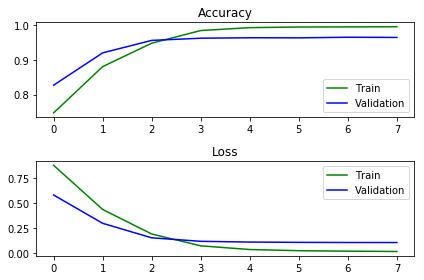

In [39]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(lstm_history.history["acc"], color="g", label="Train")
plt.plot(lstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(lstm_history.history["loss"], color="g", label="Train")
plt.plot(lstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| LSTM | Размер эмбеддинга | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 64 | нет | 0.9576 | 0.9616 | 0.1085 | 0.8861223701988035 |
| **2 модель** | 100 | нет | 0.9646 | 0.9652 | 0.1050 | 0.9044585987261147 |
| **3 модель** | 200 | 8 | 0.9619 | 0.9641 | 0.1087 | 0.898346522550344 | 

заметки по работе моделей:
- действительно, чем больше размер эмбеддинга тем раньше происходит переобучение
- в lstm лучше рекомендует себя модель с размером эмбеддинга 100: у нее лучше показатели по тестовой и валидационной точностям, точности без паддингов, а также по потерям. Однако, если бы в модели с размером эмбеддинга 200 не переобучилась на 8 эпохе, возможно, ее показатели были бы лучше, т.к. в модель подается в два раза больше параметров. Ну, и разница в показателях всего лишь в долях тысячных.
- Стоит снова упомянуть, что для польского языка мы подали в модель все токены тренировочной модели, а доля незнакомых слов довольно маленькая, поэтому модель так хорошо предсказывает теги для тестовой выборки без паддингов

### Bidirectional LSTM

In [40]:
from keras.layers.wrappers import Bidirectional
bilstm_model = Sequential()
bilstm_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
bilstm_model.add(Bidirectional(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dense(T_MAX_FEATURES))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 27, 64)            1635840   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 27, 128)           66048     
_________________________________________________________________
dense_7 (Dense)              (None, 27, 16)            2064      
_________________________________________________________________
activation_7 (Activation)    (None, 27, 16)            0         
Total params: 1,703,952
Trainable params: 1,703,952
Non-trainable params: 0
_________________________________________________________________


In [41]:
checkpoint = ModelCheckpoint('cu\\bilstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
bilstm_history = bilstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 41s 4ms/step - loss: 0.8810 - acc: 0.7570 - val_loss: 0.5941 - val_acc: 0.8118

Epoch 00001: saving model to cu\bilstm_model\cu-easy_model-1.h5
Epoch 2/8
11019/11019 [==============================] - 20s 2ms/step - loss: 0.4967 - acc: 0.8439 - val_loss: 0.3728 - val_acc: 0.8839

Epoch 00002: saving model to cu\bilstm_model\cu-easy_model-2.h5
Epoch 3/8
11019/11019 [==============================] - 23s 2ms/step - loss: 0.2816 - acc: 0.9112 - val_loss: 0.2079 - val_acc: 0.9361

Epoch 00003: saving model to cu\bilstm_model\cu-easy_model-3.h5
Epoch 4/8
11019/11019 [==============================] - 23s 2ms/step - loss: 0.1392 - acc: 0.9610 - val_loss: 0.1217 - val_acc: 0.9624

Epoch 00004: saving model to cu\bilstm_model\cu-easy_model-4.h5
Epoch 5/8
11019/11019 [==============================] - 23s 2ms/step - loss: 0.0575 - acc: 0.9884 - val_loss: 0.0988 - val_acc: 0.9664

Epoch 0000

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [42]:
bilstm_model.load_weights('cu\\bilstm_model\\cu-easy_model-8.h5')
score, acc = bilstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = bilstm_model.predict_classes(Xtest)
prediction_bilstm = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_bilstm)

1727/1727 [==============================] - 2s 997us/step
0.9683244337080252
{'accuracy w/o paddings': 0.9152673229106352}


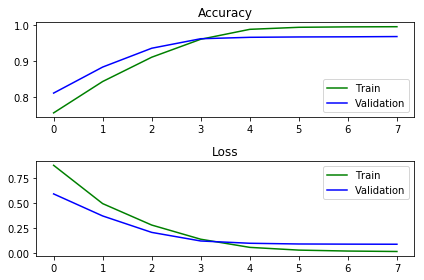

In [43]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(bilstm_history.history["acc"], color="g", label="Train")
plt.plot(bilstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(bilstm_history.history["loss"], color="g", label="Train")
plt.plot(bilstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 100

In [44]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(S_MAX_FEATURES, 100, input_length=MAX_SEQLEN))
bilstm_model.add(Bidirectional(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dense(T_MAX_FEATURES))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()
checkpoint = ModelCheckpoint('cu\\bilstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
bilstm_history = bilstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 27, 100)           2556000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 27, 128)           84480     
_________________________________________________________________
dense_8 (Dense)              (None, 27, 16)            2064      
_________________________________________________________________
activation_8 (Activation)    (None, 27, 16)            0         
Total params: 2,642,544
Trainable params: 2,642,544
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 62s 6ms/step - loss: 0.8571 - acc: 0.7684 - val_loss: 0.5472 - val_acc: 0.8208

Epoch 00001: saving model to cu\bilstm_model\cu-easy_model-1.h5
Epoch 2/8
1101

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [45]:
bilstm_model.load_weights('cu\\bilstm_model\\cu-easy_model-8.h5')
score, acc = bilstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = bilstm_model.predict_classes(Xtest)
prediction_bilstm = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_bilstm)

1727/1727 [==============================] - 1s 776us/step
0.9689034695699854
{'accuracy w/o paddings': 0.9162323875699669}


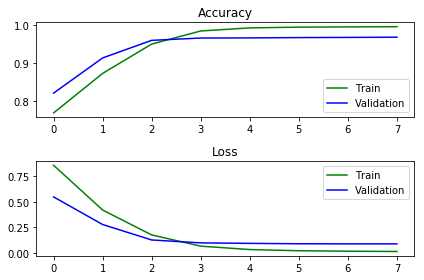

In [46]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(bilstm_history.history["acc"], color="g", label="Train")
plt.plot(bilstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(bilstm_history.history["loss"], color="g", label="Train")
plt.plot(bilstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 200

In [47]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(S_MAX_FEATURES, 200, input_length=MAX_SEQLEN))
bilstm_model.add(Bidirectional(LSTM(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dense(T_MAX_FEATURES))
bilstm_model.add(Activation("softmax"))

bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
bilstm_model.summary()
checkpoint = ModelCheckpoint('cu\\bilstm_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
bilstm_history = bilstm_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 27, 200)           5112000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 27, 128)           135680    
_________________________________________________________________
dense_9 (Dense)              (None, 27, 16)            2064      
_________________________________________________________________
activation_9 (Activation)    (None, 27, 16)            0         
Total params: 5,249,744
Trainable params: 5,249,744
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 104s 9ms/step - loss: 0.7651 - acc: 0.7875 - val_loss: 0.4476 - val_acc: 0.8695

Epoch 00001: saving model to cu\bilstm_model\cu-easy_model-1.h5
Epoch 2/8
110

переобучение на 8 эпохе, т.к. валидационная точность начинает падать

In [48]:
bilstm_model.load_weights('cu\\bilstm_model\\cu-easy_model-7.h5')
score, acc = bilstm_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = bilstm_model.predict_classes(Xtest)
prediction_bilstm = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_bilstm)

1727/1727 [==============================] - 4s 2ms/step
0.9699543193716084
{'accuracy w/o paddings': 0.9194492697677412}


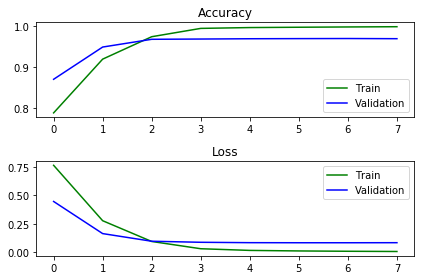

In [49]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(bilstm_history.history["acc"], color="g", label="Train")
plt.plot(bilstm_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(bilstm_history.history["loss"], color="g", label="Train")
plt.plot(bilstm_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| biLSTM | Размер эмбеддинга | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 64 | нет | 0.9683 | 0.9684 | 0.089 | 0.9152673229106352 |
| **2 модель** | 100 | нет | 0.9689 | 0.9689 | 0.0868 | 0.9162323875699669 |
| **3 модель** | 200 | 8 | 0.97 | 0.969 | 0.0851 | 0.9194492697677412 | 

заметки по работе моделей:
- переобучение происходит только при размере эмбеддинга 200
- при размере эмбеддинга 200 модель показывает самые лучшие результаты (хотя разница опять в долях тысячных). Делаем вывод для данной сетки, что чем сложнее модель, чем больше параметров мы в нее подаем, тем лучше она будет показывать результаты.

### GRU

In [50]:
gru_model = Sequential()
gru_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
gru_model.add(GRU(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model.add(Dense(T_MAX_FEATURES))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 27, 64)            1635840   
_________________________________________________________________
gru_1 (GRU)                  (None, 27, 64)            24768     
_________________________________________________________________
dense_10 (Dense)             (None, 27, 16)            1040      
_________________________________________________________________
activation_10 (Activation)   (None, 27, 16)            0         
Total params: 1,661,648
Trainable params: 1,661,648
Non-trainable params: 0
_________________________________________________________________


In [51]:
checkpoint = ModelCheckpoint('cu\\gru_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
gru_history = gru_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 57s 5ms/step - loss: 0.9559 - acc: 0.7440 - val_loss: 0.6064 - val_acc: 0.8159

Epoch 00001: saving model to cu\gru_model\cu-easy_model-1.h5
Epoch 2/8
11019/11019 [==============================] - 26s 2ms/step - loss: 0.4406 - acc: 0.8816 - val_loss: 0.2937 - val_acc: 0.9246

Epoch 00002: saving model to cu\gru_model\cu-easy_model-2.h5
Epoch 3/8
11019/11019 [==============================] - 26s 2ms/step - loss: 0.2052 - acc: 0.9457 - val_loss: 0.1628 - val_acc: 0.9506

Epoch 00003: saving model to cu\gru_model\cu-easy_model-3.h5
Epoch 4/8
11019/11019 [==============================] - 26s 2ms/step - loss: 0.0988 - acc: 0.9760 - val_loss: 0.1192 - val_acc: 0.9623

Epoch 00004: saving model to cu\gru_model\cu-easy_model-4.h5
Epoch 5/8
11019/11019 [==============================] - 33s 3ms/step - loss: 0.0519 - acc: 0.9898 - val_loss: 0.1045 - val_acc: 0.9637

Epoch 00005: saving mo

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [52]:
gru_model.load_weights('cu\\gru_model\\cu-easy_model-8.h5')
score, acc = gru_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = gru_model.predict_classes(Xtest)
prediction_gru = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_gru)

1727/1727 [==============================] - 1s 615us/step
0.9670805748515413
{'accuracy w/o paddings': 0.9110210384095735}


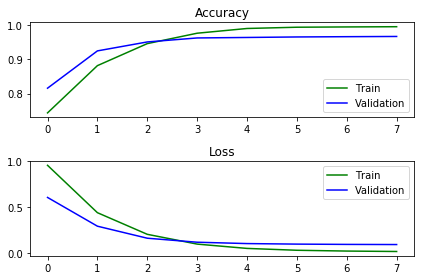

In [53]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(gru_history.history["acc"], color="g", label="Train")
plt.plot(gru_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(gru_history.history["loss"], color="g", label="Train")
plt.plot(gru_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 100

In [54]:
gru_model = Sequential()
gru_model.add(Embedding(S_MAX_FEATURES, 100, input_length=MAX_SEQLEN))
gru_model.add(GRU(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model.add(Dense(T_MAX_FEATURES))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()
checkpoint = ModelCheckpoint('cu\\gru_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
gru_history = gru_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 27, 100)           2556000   
_________________________________________________________________
gru_2 (GRU)                  (None, 27, 64)            31680     
_________________________________________________________________
dense_11 (Dense)             (None, 27, 16)            1040      
_________________________________________________________________
activation_11 (Activation)   (None, 27, 16)            0         
Total params: 2,588,720
Trainable params: 2,588,720
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 69s 6ms/step - loss: 0.9005 - acc: 0.7786 - val_loss: 0.5209 - val_acc: 0.8674

Epoch 00001: saving model to cu\gru_model\cu-easy_model-1.h5
Epoch 2/8
11019/1

переобучение на 8 эпохе, т.к. валидационная точность хоть и таже, но потери начинают расти

In [55]:
gru_model.load_weights('cu\\gru_model\\cu-easy_model-7.h5')
score, acc = gru_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = gru_model.predict_classes(Xtest)
prediction_gru = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_gru)

1727/1727 [==============================] - 2s 1ms/step
0.9648287610367122
{'accuracy w/o paddings': 0.9054236633854469}


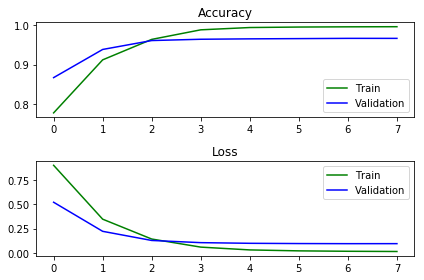

In [56]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(gru_history.history["acc"], color="g", label="Train")
plt.plot(gru_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(gru_history.history["loss"], color="g", label="Train")
plt.plot(gru_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Размер эмбеддинга 200

In [57]:
gru_model = Sequential()
gru_model.add(Embedding(S_MAX_FEATURES, 200, input_length=MAX_SEQLEN))
gru_model.add(GRU(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
gru_model.add(Dense(T_MAX_FEATURES))
gru_model.add(Activation("softmax"))

gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
gru_model.summary()
checkpoint = ModelCheckpoint('cu\\gru_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
gru_history = gru_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 27, 200)           5112000   
_________________________________________________________________
gru_3 (GRU)                  (None, 27, 64)            50880     
_________________________________________________________________
dense_12 (Dense)             (None, 27, 16)            1040      
_________________________________________________________________
activation_12 (Activation)   (None, 27, 16)            0         
Total params: 5,163,920
Trainable params: 5,163,920
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 156s 14ms/step - loss: 0.7844 - acc: 0.8171 - val_loss: 0.3647 - val_acc: 0.9113

Epoch 00001: saving model to cu\gru_model\cu-easy_model-1.h5
Epoch 2/8
11019

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [58]:
gru_model.load_weights('cu\\gru_model\\cu-easy_model-8.h5')
score, acc = gru_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = gru_model.predict_classes(Xtest)
prediction_gru = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_gru)

1727/1727 [==============================] - 1s 767us/step
0.9645070730431893
{'accuracy w/o paddings': 0.9048446245898474}


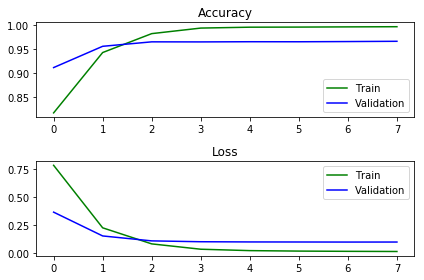

In [59]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(gru_history.history["acc"], color="g", label="Train")
plt.plot(gru_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(gru_history.history["loss"], color="g", label="Train")
plt.plot(gru_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| GRU | Размер эмбеддинга | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 64 | нет | 0.967 | 0.9666 | 0.0939 | 0.9110210384095735 |
| **2 модель** | 100 | 8 | 0.9648 | 0.9663 | 0.0951 | 0.9054236633854469 |
| **3 модель** | 200 | 8 | 0.9645 | 0.9653 | 0.0969 | 0.9048446245898474 | 

заметки по работе моделей:
- для GRU, видимо, лучше, если в нее подается меньшее кол-во параметров, если размер эмбеддинга меньше, т.к. для размера эмбеддинга 64, сетка показывает результаты лучше, чемм при его увеличении. Это логично, если учесть, что GRU это упрощенная LSTM. Возможно сетка показывает такие результаты из-за степени разнообразности входных данных.

### Шоу эксперименты
Просто меняем размер S_MAX_FEATURES (только SimpleRNN). 

- Выбрали SimpleRNN, т.к. он быстрее остальных считается.
- Решили поиграть с размером S_MAX_FEATURES, чтобы посмотреть, насколько сильно меняется точность предсказаний без паддингов в зависимости от кол-ва токенов, которые подаются в модель
- Сравниваем модели при размере эмбеддинга 64

Берем только 5000 первых токенов.

In [60]:
MAX_SEQLEN = 27
S_MAX_FEATURES = 5000
T_MAX_FEATURES = 15

In [61]:
pol_word2index = {w[0]: i + 2 for i,w in enumerate(pol_freqs.most_common(S_MAX_FEATURES))}
pol_word2index['PAD'] = 0
pol_word2index['UNK'] = 1
pol_tag2index = {t: i + 1 for i,t in enumerate(pol_tags)}
pol_tag2index['PAD'] = 0

In [62]:
S_MAX_FEATURES += 2
T_MAX_FEATURES += 1

In [63]:
X = build_tensor(pol_train_sents, pol_num, pol_word2index, MAX_SEQLEN)
Xtest = build_tensor(pol_test_sents, pol_test_num, pol_word2index, MAX_SEQLEN)
Y = build_tensor(pol_train_tags, pol_num, pol_tag2index, MAX_SEQLEN)
Ytest = build_tensor(pol_test_tags, pol_test_num, pol_tag2index, MAX_SEQLEN)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [64]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 27, 64)            320128    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 27, 64)            8256      
_________________________________________________________________
dense_13 (Dense)             (None, 27, 16)            1040      
_________________________________________________________________
activation_13 (Activation)   (None, 27, 16)            0         
Total params: 329,424
Trainable params: 329,424
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 43s 4ms/step - loss: 0.9393 - acc: 0.7429 - val_loss: 0.5955 - val_acc: 0.8473

Epoch 00001: saving model to cu\rnn_model\cu-easy_model-1.h5
Epoch 2/8
11019/11019

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [65]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-8.h5')
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_rnn)

1727/1727 [==============================] - 1s 437us/step
0.959896200160174
{'accuracy w/o paddings': 0.8913980570031527}


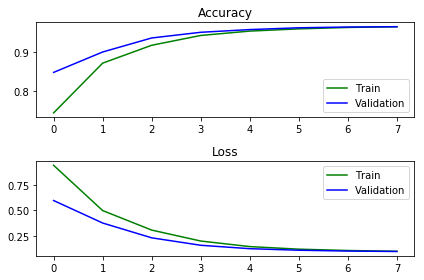

In [66]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

Берем уже 15000 токенов

In [67]:
MAX_SEQLEN = 27
S_MAX_FEATURES = 15000
T_MAX_FEATURES = 15

In [68]:
pol_word2index = {w[0]: i + 2 for i,w in enumerate(pol_freqs.most_common(S_MAX_FEATURES))}
pol_word2index['PAD'] = 0
pol_word2index['UNK'] = 1
pol_tag2index = {t: i + 1 for i,t in enumerate(pol_tags)}
pol_tag2index['PAD'] = 0

In [69]:
S_MAX_FEATURES += 2
T_MAX_FEATURES += 1

In [70]:
X = build_tensor(pol_train_sents, pol_num, pol_word2index, MAX_SEQLEN)
Xtest = build_tensor(pol_test_sents, pol_test_num, pol_word2index, MAX_SEQLEN)
Y = build_tensor(pol_train_tags, pol_num, pol_tag2index, MAX_SEQLEN)
Ytest = build_tensor(pol_test_tags, pol_test_num, pol_tag2index, MAX_SEQLEN)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [71]:
rnn_model = Sequential()
rnn_model.add(Embedding(S_MAX_FEATURES, 64, input_length=MAX_SEQLEN))
rnn_model.add(SimpleRNN(64, input_shape=(MAX_SEQLEN, S_MAX_FEATURES), unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
rnn_model.add(Dense(T_MAX_FEATURES))
rnn_model.add(Activation("softmax"))

rnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['acc'])
rnn_model.summary()
checkpoint = ModelCheckpoint('cu\\rnn_model\\cu-easy_model-{epoch}.h5', verbose=1, save_best_only=False, save_weights_only=True)
rnn_history = rnn_model.fit(Xtrain, np_utils.to_categorical(Ytrain, num_classes=T_MAX_FEATURES), batch_size=64, epochs=NUM_EPOCHS, validation_data=[Xval, np_utils.to_categorical(Yval, num_classes=T_MAX_FEATURES)], verbose=1, callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 27, 64)            960128    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 27, 64)            8256      
_________________________________________________________________
dense_14 (Dense)             (None, 27, 16)            1040      
_________________________________________________________________
activation_14 (Activation)   (None, 27, 16)            0         
Total params: 969,424
Trainable params: 969,424
Non-trainable params: 0
_________________________________________________________________
Train on 11019 samples, validate on 2755 samples
Epoch 1/8
11019/11019 [==============================] - 75s 7ms/step - loss: 0.9173 - acc: 0.7526 - val_loss: 0.5878 - val_acc: 0.8384

Epoch 00001: saving model to cu\rnn_model\cu-easy_model-1.h5
Epoch 2/8
11019/11019

т.к. валидационная точность растет на протяжении всех эпох, то переобучения нет

In [72]:
rnn_model.load_weights('cu\\rnn_model\\cu-easy_model-8.h5')
score, acc = rnn_model.evaluate(Xtest, np_utils.to_categorical(Ytest, num_classes=T_MAX_FEATURES), batch_size=64)
print(acc)
prediction = rnn_model.predict_classes(Xtest)
prediction_rnn = evaluate(Ytest, prediction, pol_test_tags)
print(prediction_rnn)

1727/1727 [==============================] - 2s 1ms/step
0.9652791235511815
{'accuracy w/o paddings': 0.9065174033326899}


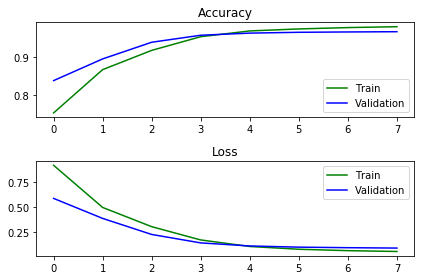

In [73]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(rnn_history.history["acc"], color="g", label="Train")
plt.plot(rnn_history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(rnn_history.history["loss"], color="g", label="Train")
plt.plot(rnn_history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

| RNN | S_MAX_FEATURES | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------------|-------------|-----------------------|----------|-----------|------------------|
| **1 модель** | 5000 | нет | 0.956 | 0.9652 | 0.0981 | 0.8913980570031527 |
| **2 модель** | 15000 | нет | 0.9653 | 0.9683 | 0.0936 | 0.9065174033326899 |
| **3 модель** | 25558 | нет | 0.9686 | 0.9662 | 0.1003 | 0.9157176864183235 | 

заметки:
- в отличие от немецкого языка, переобучения здесь не возникло. Но это вполне объяснимо: кол-во уникальных токенов здесь намного меньше, чем в немецком, поэтому в модель изначально поступает меньше параметров и она не успевает переобучиться.
- лучше показала себя модель с максимальным числом токенов для тестовой точности и точности без паддингов: для немецкого языка ситуация немного другая. Скорей всего, в тестовом корпусе для польского языка, данные были разнообразнее и не повторялись так же часто, как в немецком языке. 
- для валидационной точности и потери лучше оказалось модель с 15000 токенов: возможно, это снова можно объяснить тем, что тренировочная и валидационная выборки формировались случайно для всех трех моделей (random_state=42)

## Итоги по одинаковым размерам эмбеддинга
### Embedding 64

| модель | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------|-----------------------|----------|-----------|------------------|
| **SimpleRNN** | нет | 0.9685 | 0.9662 | 0.1003 | 0.9157176864183235 |
| **LSTM** | нет | 0.9576 | 0.9616 | 0.1085 | 0.8861223701988035 |
| **biLSTM** | нет | 0.9683 | 0.9684 | 0.089 | 0.9152673229106352 |
| **GRU** | нет | 0.967 | 0.9666 | 0.0939 | 0.9110210384095735 | 

заметки:
- за звание лучшей сетки при этом эмбеддинге борются SimpleRNN и двунаправленная LSTM. Даже, скорей всего, двунаправленная лидирует, т.к. на тестовой точности и на точности без паддингов она хуже SimpleRNN совсем на чуть-чуть, а именно на доли тысячных. Впрочем, она намного мощнее  SimpleRNN, поэтому, возможно, при больших размерах эмбеддинга она покажет результаты еще лучше.
- худшие результаты при данном эмбеддинге показывает LSTM

### Embedding 100

| модель | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------|-----------------------|----------|-----------|------------------|
| **SimpleRNN** | 8 | 0.9687 | 0.9678 | 0.097 | 0.9163610628578781 |
| **LSTM** | нет | 0.9646 | 0.9652 | 0.1050 | 0.9044585987261147 |
| **biLSTM** | нет | 0.9689 | 0.9689 | 0.0868 | 0.9162323875699669 |
| **GRU** | 8 | 0.9648 | 0.9663 | 0.0951 | 0.9054236633854469 |

заметки:
- лучше всего при эмбеддинге размером 100 работает двунаправленная LSTM, как и предполагалось выше. Она только чуть-чуть уступает SimpleRNNв точности без паддингов
- хуже себя показали LSTM и GRU, но это в принципе объяснимо тем, что эти сетки слабее двунаправленной LSTM

### Embedding 200

| модель | Переобучение на эпохе | test_acc | Best val_acc | val_loss | Acc w/o paddings |
|-----|-------------|-----------------------|----------|-----------|------------------|
| **SimpleRNN** | 8 | 0.963 | 0.9661 | 0.0994 | 0.9001479765810978 | 
| **LSTM** | 8 | 0.9619 | 0.9641 | 0.1087 | 0.898346522550344 | 
| **biLSTM** | 8 | 0.97 | 0.969 | 0.0851 | 0.9194492697677412 | 
| **GRU** | 8 | 0.9645 | 0.9653 | 0.0969 | 0.9048446245898474 | 

заметки:
- двунаправленная LSTM продолжает улучшать результаты, LSTM снова показывает результаты хуже остальных сеток, н, стоит заметить, что показатели у всех сеток не сильно отличаются друг от друга.

### Двунаправленная LSTM WINS
- все остальные чуть похуже работают, но тоже нормальные результаты показывают
- при увеличении эмбеддинга модели быстрее переобучиваются
- точность без паддингов не сильно отличается от тестовой и валидационной точностей, т.к.в тестовом корпусе часто встречались известные слова
- чем сложнее модель и сама сетка (для SimpleRNN, LSTM - Embedding 100, для двунаправленной LSTM - Embedding 200), которую мы используем, тем лучше показатели. Однако, того же нельзя сказать про GRU - ее показатели наоборот ухудшаются при увеличении размера пространства эмбеддинга
- результаты работы сеток довольно сильно зависит от языкового корпуса, который мы используем
# THE END